# Solving puzzles with mixed integer programming
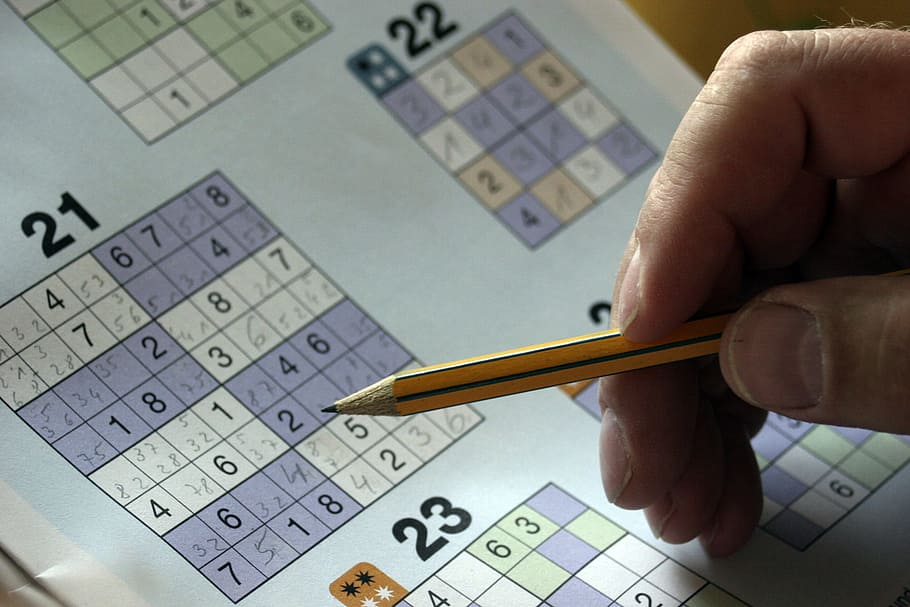

In [2]:
using JuMP, GLPK

┌ Info: Precompiling GLPK [60bf3e95-4087-53dc-ae20-288a0d20c6a6]
└ @ Base loading.jl:1260


Thanks to the group working on JuMP.jl, whose [example code](https://github.com/jump-dev/JuMP.jl/blob/master/examples/sudoku.jl) this presentation borrows from heavily.

So first, what are the rules for sudoku, for those unfamiliar? If we can express this in English, it's easier to translate it to something more mathematical and then to code.

- All boxes must contain one number in the range 1 through 9
- Each row and column must contain each number in the range only once
- Each 3x3 block must also contain each number uniquely
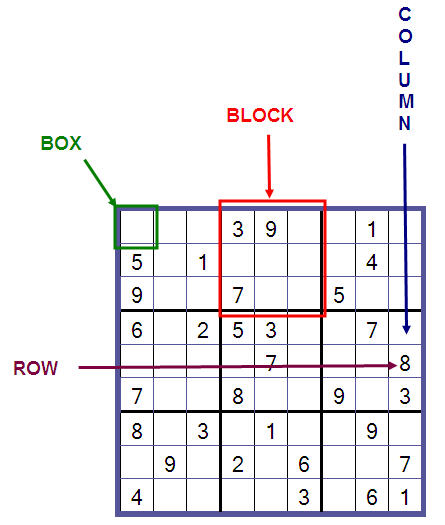

Mathematically, this looks like:
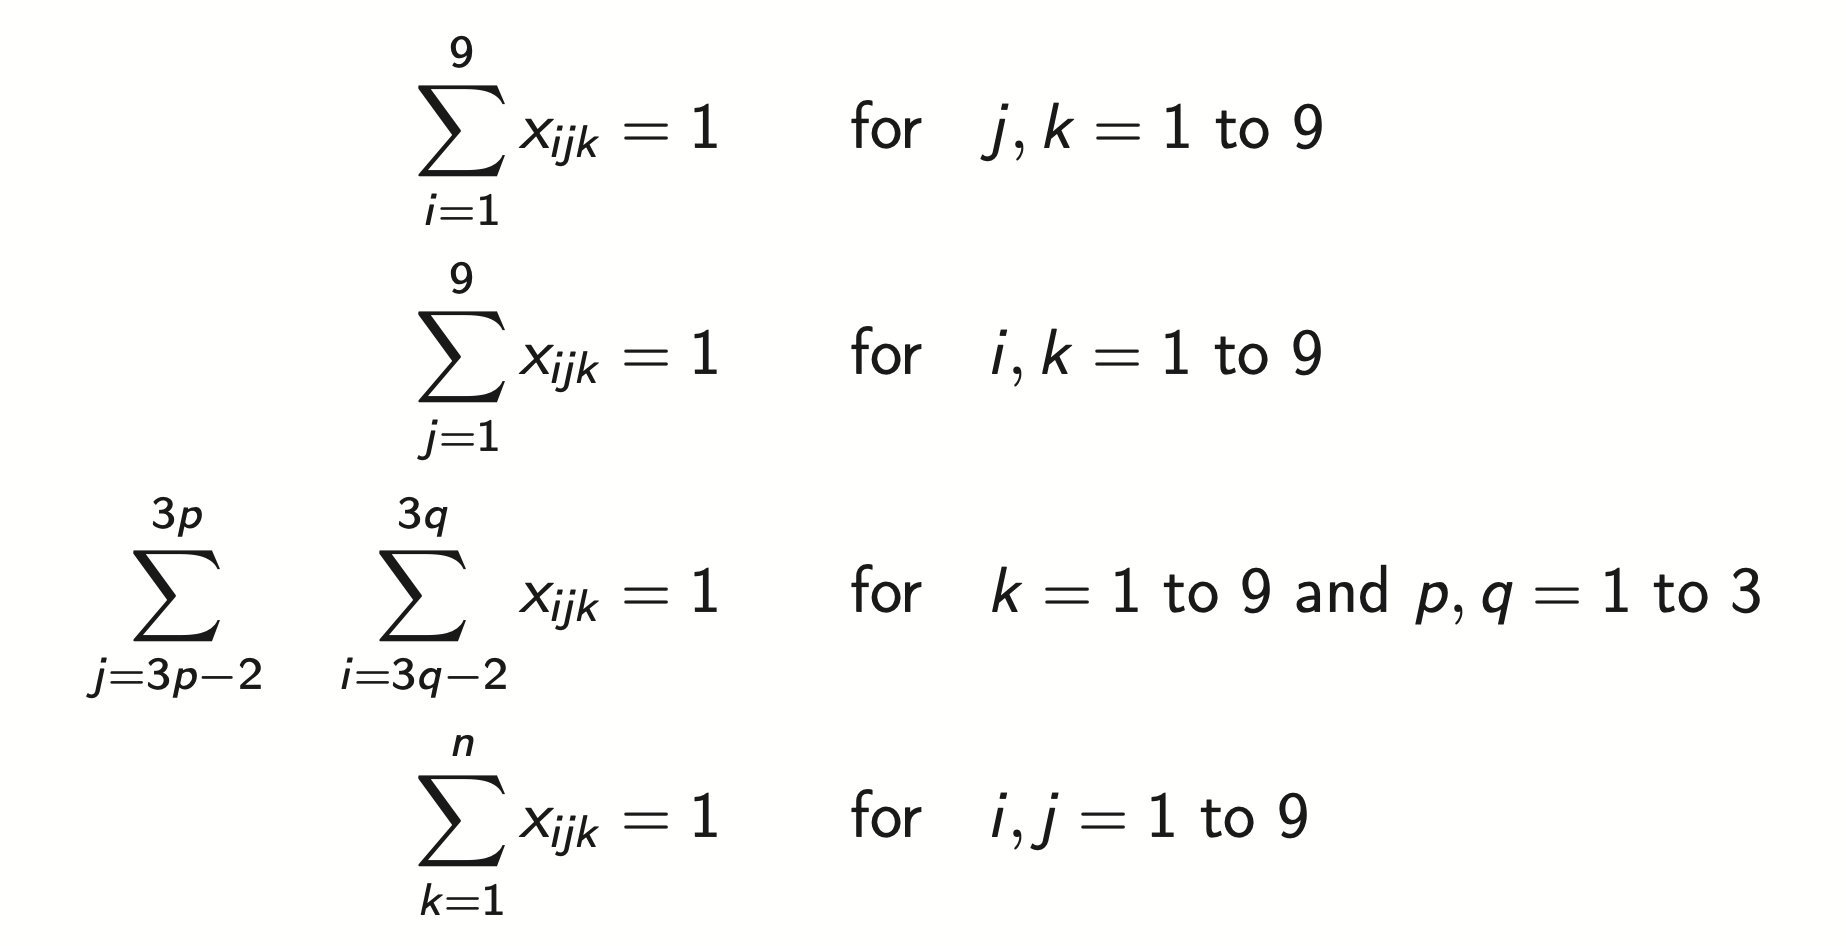
Converting this back to English, these equations read: 
1. Every row must have each number in it only once
2. Every column must have each number in it only once
3. Each block must have each number in it only once
4. Each box must have one and only one number in it

First, let's define a convenience function to visualize sudoku initial states and solutions

In [7]:
function print_sudoku(solution)
    println("Solution:")
    println("[-----------------------]")
    for row in 1:9
        print("[ ")
        for col in 1:9
            print(solution[row, col], " ")
            if col % 3 == 0 && col < 9
                print("| ")
            end
        end
        println("]")
        if row % 3 == 0
            println("[-----------------------]")
        end
    end
end

print_sudoku (generic function with 1 method)

And let's define an initial puzzle state

In [18]:
initial_grid = zeros(Int, 9, 9)
initial_grid[1,[2, 5]] = [1, 2];
initial_grid[2,[6,7]] =[8,3];
initial_grid[3,[4,5,8,9]]= [4,5,1,6]; 
initial_grid[4,[1,6]]=[1,3];
initial_grid[5,[8,9]]=[7,2];
initial_grid[6,[3,8]]=[9,4];
initial_grid[7,[1,2,4,8]] = [6,7,5,3];
initial_grid[8,[2,3,7]] = [4,2,6];
initial_grid[9,[4,6]] = [9,7];
print_sudoku(initial_grid)

Solution:
[-----------------------]
[ 0 1 0 | 0 2 0 | 0 0 0 ]
[ 0 0 0 | 0 0 8 | 3 0 0 ]
[ 0 0 0 | 4 5 0 | 0 1 6 ]
[-----------------------]
[ 1 0 0 | 0 0 3 | 0 0 0 ]
[ 0 0 0 | 0 0 0 | 0 7 2 ]
[ 0 0 9 | 0 0 0 | 0 4 0 ]
[-----------------------]
[ 6 7 0 | 5 0 0 | 0 3 0 ]
[ 0 4 2 | 0 0 0 | 6 0 0 ]
[ 0 0 0 | 9 0 7 | 0 0 0 ]
[-----------------------]


With this, we can start to use the `JuMP` optimization package in Julia to define the problem programmatically. The solver being used here is `GLPK` (GNU Linear Programming Kit), which includes a few different methods for solving integer problems. Part of what makes sudoku interesting though is that there's no score. There is only one solution defined by being feasible, in other words, fitting the rules of the game.

In [19]:
model = Model(GLPK.Optimizer)

@variable(model, x[1:9, 1:9, 1:9], Bin)

@constraints(model, begin
    # Constraint 1 - Only one value appears in each cell
    cell[i in 1:9, j in 1:9], sum(x[i, j, :]) == 1
    # Constraint 2 - Each value appears in each row once only
    row[i in 1:9, k in 1:9], sum(x[i, :, k]) == 1
    # Constraint 3 - Each value appears in each column once only
    col[j in 1:9, k in 1:9], sum(x[:, j, k]) == 1
    # Constraint 4 - Each value appears in each 3x3 subgrid once only
    subgrid[i=1:3:7, j=1:3:7, val=1:9], sum(x[i:i + 2, j:j + 2, val]) == 1
end)

# Initial solution
for row in 1:9, col in 1:9
    if initial_grid[row, col] != 0
        @constraint(model, x[row, col, initial_grid[row, col]] == 1)
    end
end

# Solve it
JuMP.optimize!(model)

Great, we have a solution! But it's still worth checking that the solver exited with an optimal solution and didn't just time out.

In [22]:
term_status = JuMP.termination_status(model)
primal_status = JuMP.primal_status(model)
is_optimal = term_status == MOI.OPTIMAL
(term_status, primal_status)

(MathOptInterface.OPTIMAL, MathOptInterface.FEASIBLE_POINT)

Now that we have a solution that works, let's convert it back to a form we can more easily visualize.

In [23]:
mip_solution = JuMP.value.(x)
sol = zeros(Int, 9, 9)
for row in 1:9, col in 1:9, val in 1:9
    if mip_solution[row, col, val] >= 0.9
        sol[row, col] = val
    end
end

In [24]:
print_sudoku(sol)

Solution:
[-----------------------]
[ 5 1 7 | 3 2 6 | 4 9 8 ]
[ 4 9 6 | 1 7 8 | 3 2 5 ]
[ 2 8 3 | 4 5 9 | 7 1 6 ]
[-----------------------]
[ 1 2 4 | 7 8 3 | 5 6 9 ]
[ 8 3 5 | 6 9 4 | 1 7 2 ]
[ 7 6 9 | 2 1 5 | 8 4 3 ]
[-----------------------]
[ 6 7 8 | 5 4 2 | 9 3 1 ]
[ 9 4 2 | 8 3 1 | 6 5 7 ]
[ 3 5 1 | 9 6 7 | 2 8 4 ]
[-----------------------]


But let's say we want to do something really crazy, like solve n-dimensional sudokus. Now, there are some really elaborate layouts out there, but let's assume that we're interest in the same general layout, just with dimensions that follow the n^2 pattern (so 4x4, 9x9, 16x16, etc.)

We can do this with some relatively simple changes to the code, starting with visualization.

In [34]:
function print_sudoku_n(solution)
    puzzle_dim = size(solution,1)
    println("Solution:")
    println("[-----------------------]")
    for row in 1:puzzle_dim
        print("[ ")
        for col in 1:puzzle_dim
            print(string(solution[row, col], pad=2), " ")
            if col % sqrt(puzzle_dim) == 0 && col < puzzle_dim
                print("| ")
            end
        end
        println("]")
        if row % sqrt(puzzle_dim) == 0
            println("[-----------------------]")
        end
    end
end

print_sudoku_n (generic function with 1 method)

In [36]:
giant_sudoku = zeros(Int,16,16)

giant_sudoku[1, [1,2,10,13,15]] = [8,7,3,13,4]
giant_sudoku[2, [2,3,7,8,9,10,11,14]] = [5,14,3,10,15,9,1,6]
giant_sudoku[3, [1,5,6,7,10,13,15,16]] = [16,5,8,7,14,9,11,12]
giant_sudoku[4, [3,6,7,8,10,11,12,14,16]] = [4,14,6,13,11,10,12,7,3]
giant_sudoku[5, [1,4,7,12,13,14,15]] = [14,8,1,3,7,4,12]
giant_sudoku[6, [1,6,7,8,11,12,14,15]] = [9,6,15,12,13,14,3,1]
giant_sudoku[7, [1,3,4,7,10,12,15]] = [11,10,3,13,8,1,6]
giant_sudoku[8, [1,4,5,7,10,12,13,16]] = [6,1,14,4,5,9,11,13]
giant_sudoku[9, [5,11,13,15,16]] = [15,9,5,2,10]
giant_sudoku[10, [1,2,5,7,9,10,11,12]] = [10,1,6,5,13,15,7,16]
giant_sudoku[11, [3,4,6,8,9,14,16]] = [16,11,4,8,2,13,7]
giant_sudoku[12, [2,4,5,6,8,9,11,12,13,14,15,16]] = [9,7,1,3,2,6,8,10,16,15,14,4]
giant_sudoku[13, [1,3,5,6,8,11,12,13,14,16]] = [7,13,9,16,5,14,4,3,8,2]
giant_sudoku[14, [3,5,14,15]] = [3,10,16,15]
giant_sudoku[15, [1,3,7,8,15]] = [1,9,14,4,7]
giant_sudoku[16, [2,3,5,9,10]] = [6,8,3,10,7]

print_sudoku_n(giant_sudoku)

Solution:
[-----------------------]
[ 08 07 00 00 | 00 00 00 00 | 00 03 00 00 | 13 00 04 00 ]
[ 00 05 14 00 | 00 00 03 10 | 15 09 01 00 | 00 06 00 00 ]
[ 16 00 00 00 | 05 08 07 00 | 00 14 00 00 | 09 00 11 12 ]
[ 00 00 04 00 | 00 14 06 13 | 00 11 10 12 | 00 07 00 03 ]
[-----------------------]
[ 14 00 00 08 | 00 00 01 00 | 00 00 00 03 | 07 04 12 00 ]
[ 09 00 00 00 | 00 06 15 12 | 00 00 13 14 | 00 03 01 00 ]
[ 11 00 10 03 | 00 00 13 00 | 00 08 00 01 | 00 00 06 00 ]
[ 06 00 00 01 | 14 00 04 00 | 00 05 00 09 | 11 00 00 13 ]
[-----------------------]
[ 00 00 00 00 | 15 00 00 00 | 00 00 09 00 | 05 00 02 10 ]
[ 10 01 00 00 | 06 00 05 00 | 13 15 07 16 | 00 00 00 00 ]
[ 00 00 16 11 | 00 04 00 08 | 02 00 00 00 | 00 13 00 07 ]
[ 00 09 00 07 | 01 03 00 02 | 06 00 08 10 | 16 15 14 04 ]
[-----------------------]
[ 07 00 13 00 | 09 16 00 05 | 00 00 14 04 | 03 08 00 02 ]
[ 00 00 03 00 | 10 00 00 00 | 00 00 00 00 | 00 16 15 00 ]
[ 01 00 09 00 | 00 00 14 04 | 00 00 00 00 | 00 00 07 00 ]
[ 00 06 08 00 | 

In [45]:
function sudoku_n_solver(initial_grid)
    puzzle_size = size(initial_grid,1)
    cell_size = Int(sqrt(puzzle_size))
    
    model = Model(GLPK.Optimizer)

    @variable(model, x[1:puzzle_size, 1:puzzle_size, 1:puzzle_size], Bin)

    @constraints(model, begin
        # Constraint 1 - Only one value appears in each cell
        cell[i in 1:puzzle_size, j in 1:puzzle_size], sum(x[i, j, :]) == 1
        # Constraint 2 - Each value appears in each row once only
        row[i in 1:puzzle_size, k in 1:puzzle_size], sum(x[i, :, k]) == 1
        # Constraint 3 - Each value appears in each column once only
        col[j in 1:puzzle_size, k in 1:puzzle_size], sum(x[:, j, k]) == 1
        # Constraint 4 - Each value appears in each subgrid once only
        subgrid[i=1:cell_size:(2*cell_size+1), 
                j=1:cell_size:(2*cell_size+1), 
                val=1:puzzle_size], sum(x[i:i + cell_size - 1, j:j + cell_size - 1, val]) == 1
    end)

    # Initial solution
    for row in 1:puzzle_size, col in 1:puzzle_size
        if initial_grid[row, col] != 0
            @constraint(model, x[row, col, initial_grid[row, col]] == 1)
        end
    end

    # Solve it
    JuMP.optimize!(model)

    term_status = JuMP.termination_status(model)
    primal_status = JuMP.primal_status(model)
    is_optimal = term_status == MOI.OPTIMAL

    # Check solution
    if is_optimal
        mip_solution = JuMP.value.(x)
        sol = zeros(Int, puzzle_size, puzzle_size)
        for row in 1:puzzle_size, col in 1:puzzle_size, val in 1:puzzle_size
            if mip_solution[row, col, val] >= 0.9
                sol[row, col] = val
            end
        end
        return sol
    else
        error("The solver did not find an optimal solution.")
    end
end

sudoku_n_solver (generic function with 1 method)

In [47]:
giant_soln = sudoku_n_solver(giant_sudoku)
print_sudoku_n(giant_soln)

Solution:
[-----------------------]
[ 08 07 11 10 | 02 12 09 01 | 05 03 16 06 | 13 14 04 15 ]
[ 12 05 14 13 | 04 11 03 10 | 15 09 01 07 | 02 06 16 08 ]
[ 16 03 01 06 | 05 08 07 15 | 04 14 02 13 | 09 10 11 12 ]
[ 02 15 04 09 | 16 14 06 13 | 08 11 10 12 | 01 07 05 03 ]
[-----------------------]
[ 14 13 15 08 | 11 02 01 09 | 16 10 06 03 | 07 04 12 05 ]
[ 09 04 07 05 | 08 06 15 12 | 11 02 13 14 | 10 03 01 16 ]
[ 11 02 10 03 | 07 05 13 16 | 12 08 04 01 | 15 09 06 14 ]
[ 06 16 12 01 | 14 10 04 03 | 07 05 15 09 | 11 02 08 13 ]
[-----------------------]
[ 03 08 06 12 | 15 13 16 07 | 14 04 09 11 | 05 01 02 10 ]
[ 10 01 02 04 | 06 09 05 14 | 13 15 07 16 | 08 12 03 11 ]
[ 15 14 16 11 | 12 04 10 08 | 02 01 03 05 | 06 13 09 07 ]
[ 13 09 05 07 | 01 03 11 02 | 06 12 08 10 | 16 15 14 04 ]
[-----------------------]
[ 07 11 13 15 | 09 16 12 05 | 01 06 14 04 | 03 08 10 02 ]
[ 05 12 03 14 | 10 07 08 06 | 09 13 11 02 | 04 16 15 01 ]
[ 01 10 09 02 | 13 15 14 04 | 03 16 05 08 | 12 11 07 06 ]
[ 04 06 08 16 | 

So that's neat and all, but where is this used in the real world? Mixed integer (or just integer) programming is used in:
- Scheduling (jobs can only be assigned to certain slots, or have to occur in a certain sequence)
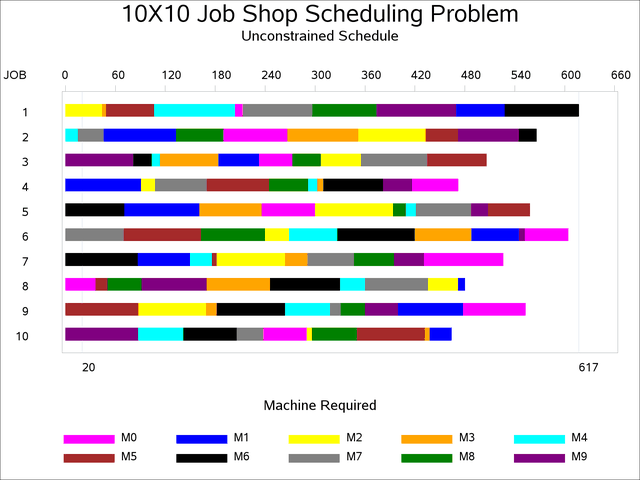
- Cell towers figuring out how to distributing available frequencies to minimize interference
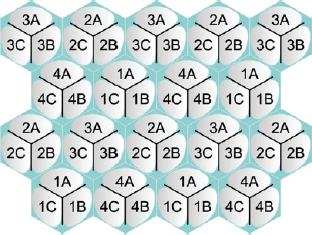
- Factory production and profitability optimization (how do we produce the most of the most profitable products?)
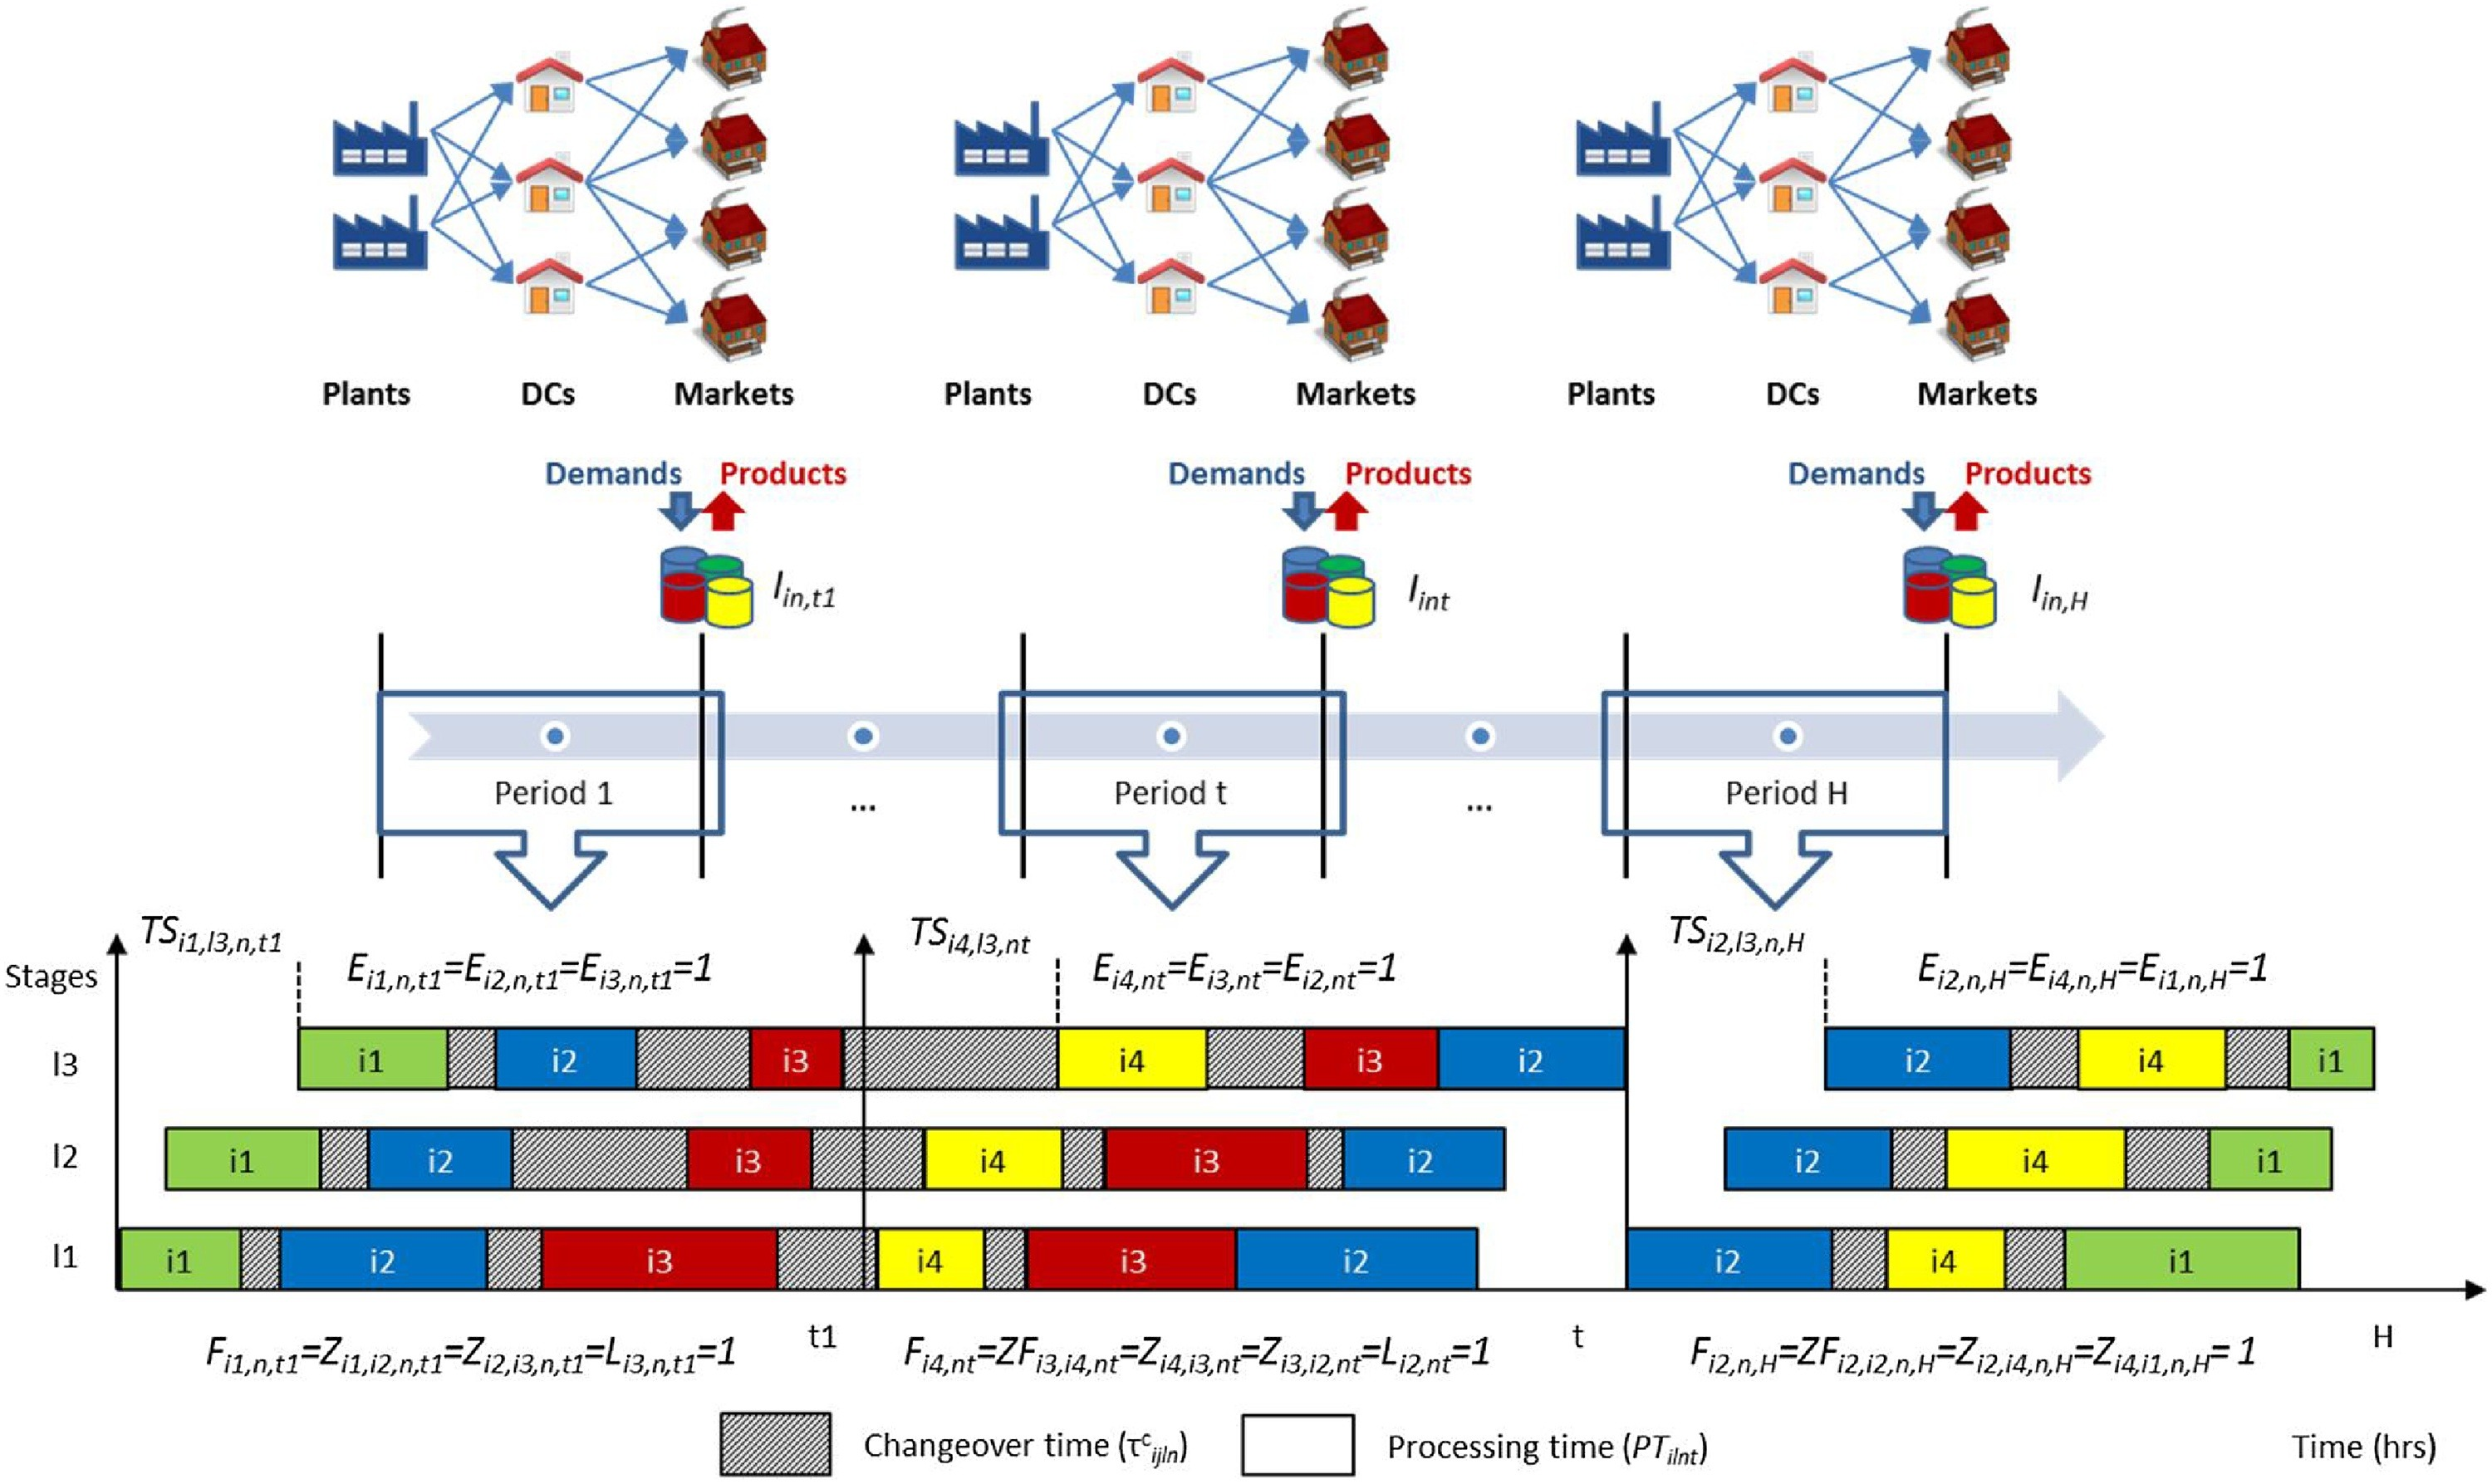


Sources for this notebook not already mentioned include:
- [Rules graphic](https://www.sudokukingdom.com/rules.php)
- [Sudoku mathematical expressions](http://profs.sci.univr.it/~rrizzi/classes/PLS2015/sudoku/doc/497_Olszowy_Wiktor_Sudoku.pdf)
- [Sample sudoku puzzles and solutions](http://www.sudoku-download.net/sudoku_9x9.php)
- [Integer Programming - Wikipedia](https://en.wikipedia.org/wiki/Integer_programming)
- [SAS schedule optimization](https://documentation.sas.com/?docsetId=orcpug&docsetTarget=orcpug_clp_examples14.htm&docsetVersion=15.1&locale=en)
- [Cell tower frequency distribution](https://www.nap.edu/read/21729/chapter/11#198)
- [Optimisation approaches for supply chain planning and scheduling under demand uncertainty](https://www.sciencedirect.com/science/article/pii/S0263876218304155)